In [140]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Extracting the data to be fitted

In [142]:
# # Extract excel data into dataframe format using Pandas
# steel_316L_4404_df = pd.read_excel('steel_316L_4404_result.xlsx', engine='openpyxl')
# steel_316L_4420_df = pd.read_excel('steel_316L_4420_result.xlsx', engine='openpyxl')
# # converting the pandas series to numpy arrays
# steel_316L_4404_grain_diameter = steel_316L_4404_df['grain_diameter'].to_numpy()
# steel_316L_4420_grain_diameter = steel_316L_4420_df['grain_diameter'].to_numpy()
# # checking the shape of the arrays
# print(steel_316L_4404_grain_diameter.shape)
# print(steel_316L_4420_grain_diameter.shape)

# Extract excel data into dataframe format using Pandas
steel_316L_4404_df = pd.read_excel('steel_316L_4404_grain_size_probability.xlsx', engine='openpyxl')
steel_316L_4420_df = pd.read_excel('steel_316L_4420_grain_size_probability.xlsx', engine='openpyxl')
# converting the pandas series to numpy arrays
steel_316L_4404_low_bin = steel_316L_4404_df['low_bin'].to_numpy()
steel_316L_4404_high_bin = steel_316L_4404_df['high_bin'].to_numpy()
steel_316L_4404_probability = steel_316L_4404_df['probability'].to_numpy()
steel_316L_4420_low_bin = steel_316L_4420_df['low_bin'].to_numpy()
steel_316L_4420_high_bin = steel_316L_4420_df['high_bin'].to_numpy()
steel_316L_4420_probability = steel_316L_4420_df['probability'].to_numpy()

### Important

during the fitting process, if you want to fit a PDF (probability density function) to the empirical probabilities, each bin's probability should be multiplied by its corresponding bin width to reflect the relationship between probability and density.

In [146]:
from distributions_pdf import *
from distributions_cdf import *
from scipy.optimize import minimize

distribution_pdf_dict = {
    "normal": normal_pdf,
    "lognormal": lognormal_pdf,
    "lognormal_offset_scaled": lognormal_offset_scaled_pdf,
    "beta": beta_pdf,
}

distribution_cdf_dict = {
    "normal": normal_cdf,
    "lognormal": lognormal_cdf,
    #"lognormal_offset_scaled": lognormal_offset_scaled_cdf,
    "beta": beta_cdf,
}

def kullback_leibler_divergence(params, low_bin, high_bin, probability, pdf_function):
    """
    Compute the Kullback-Leibler (KL) divergence between the true and estimated distributions.
    """
    # Compute the PDF-integrated values over each bin
    pdf_integral = np.array([
        np.trapz(pdf_function(np.linspace(low, high, 100), *params), 
        dx=(high - low) / 100)
        for low, high in zip(low_bin, high_bin)
    ])
    pdf_integral /= np.sum(pdf_integral)  # Normalize PDF-integral to ensure it sums to 1

    # Add a small constant to prevent log(0) or division by zero
    pdf_integral = np.maximum(pdf_integral, 1e-10)
    probability_adjusted = np.maximum(probability, 1e-10)

    # Compute KL divergence
    return np.sum(probability_adjusted * np.log(probability_adjusted / pdf_integral))


# def kullback_leibler_divergence(params, x_data, density, pdf_function):
#     """
#     Compute the Kullback-Leibler (KL) divergence between the true and estimated distributions.

#     params: tuple - Parameters to optimize (e.g., mean and std for normal distribution)
#     x_data: array - Observed data points
#     density: array - True probability density values associated with x_data (empirical probabilities)
#     pdf_function: function - Probability density function (PDF) to optimize

#     Returns:
#         KL divergence value.
#     """
#     q_model = pdf_function(x_data, *params)  # Model distribution Q(x)
#     q_model = np.where(q_model > 0, q_model, 1e-10)  # Prevent log(0)
#     q_model /= np.sum(q_model)  # Normalize model PDF
#     density /= np.sum(density)  # Normalize empirical density

#     return np.sum(density * np.log(density / q_model))  # KL Divergence


def negative_log_likelihood(params, low_bin, high_bin, probability, pdf_function):
    """
    Compute the negative log-likelihood for binned data.
    """
    # Compute the PDF-integrated values over each bin
    pdf_integral = np.array([
        np.trapz(
            pdf_function(np.linspace(low, high, 1000), *params),  # Use more points (1000) for accuracy
            dx=(high - low) / 1000
        )
        for low, high in zip(low_bin, high_bin)
    ])
    
    total = np.sum(pdf_integral)
    if total <= 0:
        return np.inf  # Return infinity for invalid parameters
    
    # Normalize to ensure probabilities sum to 1 within the bins
    q = pdf_integral / total
    q = np.clip(q, 1e-10, 1)  # Avoid log(0)
    
    # Compute negative log-likelihood
    return -np.sum(probability * np.log(q))

def fit_distribution_bins(low_bin, high_bin, probability, distribution = 'lognormal_offset_scaled'): 
    """
    Fit a probability distribution to binned data using Maximum Likelihood Estimation (MLE).

    Parameters:
        low_bin (array): Lower edges of bins.
        high_bin (array): Upper edges of bins.
        probability (array): Probability for each bin.
        distribution (str): The name of the distribution to fit.

    Returns:
        best_params (tuple): Estimated distribution parameters.
        log_likelihood (float): Log-likelihood value for the fit.
    """

    # Compute bin centers
    bin_centers = (low_bin + high_bin) / 2
    bin_widths = high_bin - low_bin

    # IMPORTANT!
    # Normalize probability values if they are not yet sum to 1
    # Usually probability must sum up to 1 before passing into this function
    probability = probability / np.sum(probability)  
    
    
    # Select custom PDF
    if distribution not in distribution_pdf_dict:
        raise ValueError(f"⚠️ Distribution '{distribution}' not found. Choose from {list(distribution_pdf_dict.keys())}")

    pdf_function = distribution_pdf_dict[distribution]

    # Initial parameter guesses based on the selected distribution
    if distribution == "normal":
        initial_guess = [np.mean(bin_centers), np.std(bin_centers)] # Mean and Standard Deviation
    elif distribution == "lognormal":
        initial_guess = [np.log(np.mean(bin_centers)), np.std(np.log(bin_centers))] # Mean and Standard Deviation
    elif distribution == "lognormal_offset_scaled":
        # Initial guess for lognormal_offset_scaled parameters
        y0_guess = np.min(probability) * 0.1  # Small offset
        A_guess = np.max(probability) - y0_guess  # Amplitude
        w_guess = np.std(np.log(bin_centers[bin_centers > 0]))  # Shape (width)
        c_guess = np.mean(np.log(bin_centers[bin_centers > 0]))  # Location (peak)
        
        initial_guess = [y0_guess, A_guess, w_guess, c_guess]
    elif distribution == "beta":
        initial_guess = [1, 1]  # Alpha and Beta parameters

    # Perform Maximum Likelihood Estimation (MLE) using optimization
    result = minimize(fun=negative_log_likelihood, x0=initial_guess, 
                    args=(low_bin, high_bin, probability, pdf_function), method='BFGS',tol=1e-3)

    if result.success:
        best_params = result.x
        best_fun = result.fun
        return best_params, best_fun
    else:
        raise RuntimeError(f"⚠️ Optimization failed: {result.message}")

In [147]:
# Fit distributions to the data using our custom PDFs
best_fit_4404, KL_div_4404 = fit_distribution_bins(
    steel_316L_4404_df['low_bin'].to_numpy(), 
    steel_316L_4404_df['high_bin'].to_numpy(), 
    steel_316L_4404_df['probability'].to_numpy(), 
    distribution="lognormal"
)

best_fit_4420, KL_div_4420 = fit_distribution_bins(
    steel_316L_4420_df['low_bin'].to_numpy(), 
    steel_316L_4420_df['high_bin'].to_numpy(), 
    steel_316L_4420_df['probability'].to_numpy(), 
    distribution="lognormal"
)

print(f"✅ 316L_4404 Best Fit: {best_fit_4404}, KL divergence: {KL_div_4404}")
print(f"✅ 316L_4420 Best Fit: {best_fit_4420}, KL divergence: {KL_div_4420}")

✅ 316L_4404 Best Fit: [1.93078507 0.8343917 ], KL divergence: 2.1173246559083667
✅ 316L_4420 Best Fit: [1.57607187 0.65433196], KL divergence: 1.857500845647124


C:\Users\nguyenb5\AppData\Local\Temp\ipykernel_25520\1919025530.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(


[0.02248144 0.16203014 0.2075045  0.17094471 0.12838014 0.09456644
 0.06981266 0.05202464 0.03922297 0.02992866 0.0231037 ]


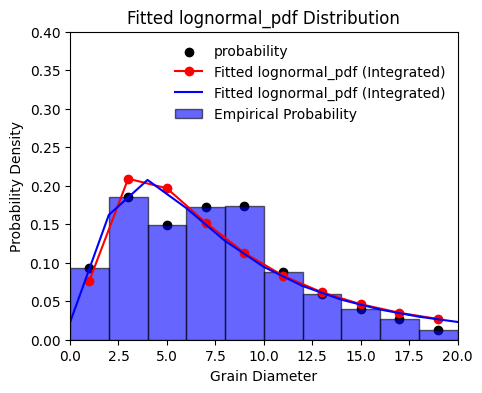

[3.55779348e-21 4.06022645e-15 1.42184752e-12 ... 5.93256175e-05
 5.90699562e-05 5.88155132e-05]


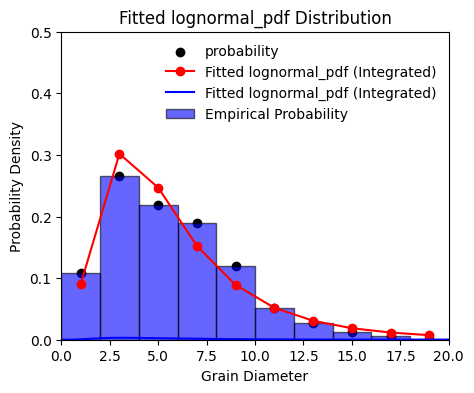

In [166]:
# Plot the fitted distribution using the optimized parameters
def plot_fitted_distribution(new_x, low_bin, high_bin, probability,
                        x_lim, y_lim, best_params, pdf_function, dist_name):
    bin_centers = (low_bin + high_bin) / 2
    bin_widths = high_bin - low_bin  # Compute bin widths

    # Compute the PDF-integrated values over each bin
    pdf_integral = np.array([
        np.trapezoid(
            pdf_function(np.linspace(low, high, 100), *best_params),  # Use more points for accuracy
            dx=(high - low) / 100
        )
        for low, high in zip(low_bin, high_bin)
    ])

    # Normalize the PDF-integral to sum to 1
    pdf_integral /= np.sum(pdf_integral)

    # Compute the PDF-integrated values over a finer grid (new_x)
    # Create a sliding window to compute the integral over small intervals in new_x
    dx = new_x[1] - new_x[0]  # Step size in new_x
    pdf_integral_smooth = np.array([
        np.trapezoid(
            pdf_function(np.linspace(max(x - dx/2, 0), x + dx/2, 100), *best_params),  # Ensure x - dx/2 >= 0
            dx=dx/100
        )
        for x in new_x
    ])

    # Normalize the smooth PDF-integral to sum to 1
    pdf_integral_smooth /= np.sum(pdf_integral_smooth)
    print(pdf_integral_smooth)


    # NOTE: The bin width must be constant for all bins. Otherwise it cannot be plotted
    bin_width = high_bin[0] - low_bin[0]
    plt.figure(figsize=(5, 4))
    # plt.scatter(bin_centers, probability/bin_width, label="probability", color="black")
    # plt.bar(bin_centers, probability/bin_width, width=bin_widths, alpha=0.6, color="blue", edgecolor="black", label="Empirical Probability")

    plt.scatter(bin_centers, probability, label="probability", color="black")
    plt.bar(bin_centers, probability, width=bin_widths, alpha=0.6, color="blue", edgecolor="black", label="Empirical Probability")
    # Plot fitted PDF-integrated probabilities
    plt.plot(bin_centers, pdf_integral, 'ro-', label=f"Fitted {dist_name} (Integrated)")
# Plot fitted PDF-integrated probabilities (smooth)
    plt.plot(new_x, pdf_integral_smooth, 'blue', label=f"Fitted {dist_name} (Integrated)")
    plt.legend(frameon=False)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.xlabel("Grain Diameter")
    plt.ylabel("Probability Density")
    plt.title(f"Fitted {dist_name} Distribution")
    plt.show()

new_x = np.linspace(0, 20, 11)
x_lim = (0, 20)
y_lim = (0, 0.4)
# Plot for Steel 316L_4404
plot_fitted_distribution(
    new_x,
    steel_316L_4404_df['low_bin'], 
    steel_316L_4404_df['high_bin'], 
    steel_316L_4404_df['probability'], 
    x_lim, y_lim, 
    best_fit_4404, 
    lognormal_pdf, 
    "lognormal_pdf"
)

new_x = np.linspace(0, 20, 1001)
x_lim = (0, 20)
y_lim = (0, 0.5)
# Plot for Steel 316L_4420
plot_fitted_distribution(
    new_x,
    steel_316L_4420_df['low_bin'], 
    steel_316L_4420_df['high_bin'], 
    steel_316L_4420_df['probability'], 
    x_lim, y_lim, 
    best_fit_4420, 
    lognormal_pdf, 
    "lognormal_pdf"
)

C:\Users\nguyenb5\AppData\Local\Temp\ipykernel_25520\2615683670.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(


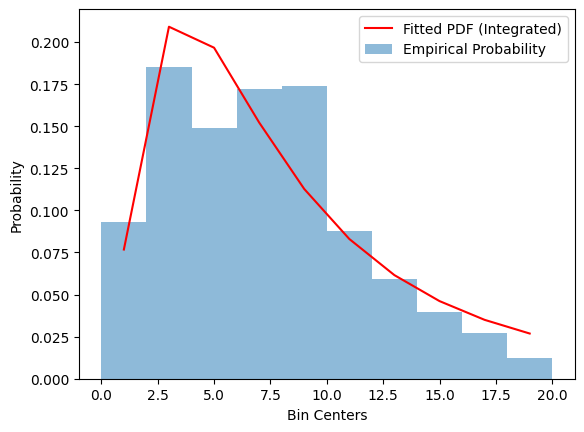

In [150]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fitted_distribution(low_bin, high_bin, probability, pdf_function, best_params):
    """
    Plot the empirical probabilities and the fitted PDF.
    """
    # Compute bin centers and widths
    bin_centers = (low_bin + high_bin) / 2
    bin_widths = high_bin - low_bin

    # Compute the PDF-integrated values over each bin
    pdf_integral = np.array([
        np.trapz(
            pdf_function(np.linspace(low, high, 1000), *best_params),  # Use more points for accuracy
            dx=(high - low) / 1000
        )
        for low, high in zip(low_bin, high_bin)
    ])

    # Normalize the PDF-integral to sum to 1
    pdf_integral /= np.sum(pdf_integral)

    # Plot empirical probabilities
    plt.bar(bin_centers, probability, width=bin_widths, alpha=0.5, label='Empirical Probability')

    # Plot fitted PDF-integrated probabilities
    plt.plot(bin_centers, pdf_integral, 'r-', label='Fitted PDF (Integrated)')

    plt.xlabel('Bin Centers')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

# Example usage
plot_fitted_distribution(steel_316L_4404_low_bin, steel_316L_4404_high_bin, steel_316L_4404_probability, lognormal_pdf, best_fit_4404)  